In [ ]:
# 내 구글 드라이브에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# yolov3.weights 파일 다운로드
from urllib.request import urlretrieve
urlretrieve('https://pjreddie.com/media/files/yolov3.weights','yolov3.weights')

('yolov3.weights', <http.client.HTTPMessage at 0x7f79bd0d6550>)

In [ ]:
# yolov3-tiny.weights 파일 다운로드
from urllib.request import urlretrieve
urlretrieve('https://pjreddie.com/media/files/yolov3-tiny.weights','yolov3-tiny.weights')

('yolov3-tiny.weights', <http.client.HTTPMessage at 0x7f79bc42e5f8>)

In [ ]:
# yolov3.weights/yolov3-tiny.weights 파일 이동
!mv yolov3.weights gdrive/My\ Drive/CV/Object\ Detection_YOLO/
print('yolov3.weights move complete!!')
!mv yolov3-tiny.weights gdrive/My\ Drive/CV/Object\ Detection_YOLO/
print('yolov3-tiny.weights move complete!!')

yolov3.weights move complete!!
yolov3-tiny.weights move complete!!


In [ ]:
# yolov3.cfg/yolov3-tiny.cfg/coco.names 다운로드

# Colab에서 GitHub 에 있는 데이터 가져오기
# 다운로드 할 수 있는 URL : https://github.com/pjreddie/darknet
# Clone Web URL 를 복사해 옵니다.

!git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5907, done.
remote: Total 5907 (delta 0), reused 0 (delta 0), pack-reused 5907
Receiving objects: 100% (5907/5907), 6.32 MiB | 2.17 MiB/s, done.
Resolving deltas: 100% (3923/3923), done.


In [ ]:
# 필요한 파일만 복사
!cp darknet/cfg/yolov3.cfg gdrive/My\ Drive/CV/Object\ Detection_YOLO/
print('yolov3.cfg copy complete!!')
!cp darknet/cfg/yolov3-tiny.cfg gdrive/My\ Drive/CV/Object\ Detection_YOLO/
print('yolov3-tiny.cfg copy complete!!')
!cp darknet/data/coco.names gdrive/My\ Drive/CV/Object\ Detection_YOLO/
print('coco.names copy complete!!')

yolov3.cfg copy complete!!
yolov3-tiny.cfg copy complete!!
coco.names copy complete!!


In [ ]:
# 다운로드 받았던 파일 제거(선택사항)
!rm -r darknet

In [ ]:
# 필요한 패키지와 모듈을 불러옴
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
# OpenCV 버전 확인
print("OpenCV version:")
print(cv2.__version__)

OpenCV version:
4.1.2


In [ ]:
# detection 으로 인정할 최소 확률(신뢰도) 지정
min_confidence = 0.5

In [ ]:
# Load YOLO
net = cv2.dnn.readNet("gdrive/My Drive/CV/Object Detection_YOLO/yolov3.weights", "gdrive/My Drive/CV/Object Detection_YOLO/yolov3.cfg")
classes = []   # detection 할 Object(Class) list 배열을 정의
with open("gdrive/My Drive/CV/Object Detection_YOLO/coco.names", "r") as f:
   classes = [line.strip() for line in f.readlines()]   # 80개의 Object(class)를 구분할 수 있는 Object의 이름을 classes 배열에 넣어준다.
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))  # Object 마다 컬러를 하나씩 다르게 지정

#### Original Image ####


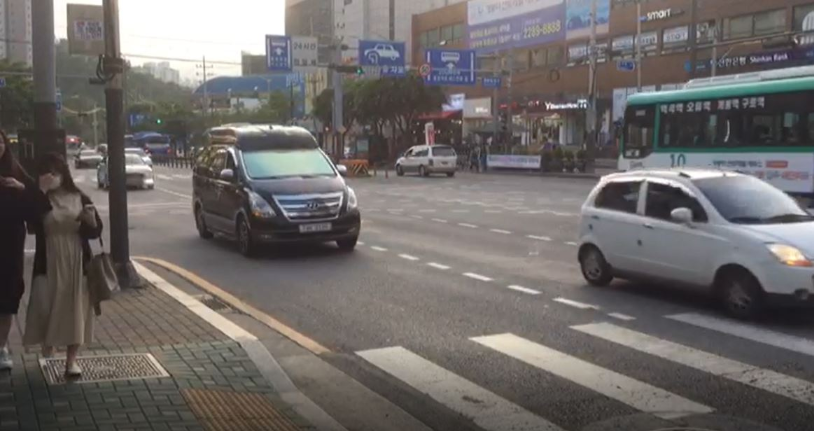

In [ ]:
# 원본이미지를 읽어 옵니다. 
img = cv2.imread("gdrive/My Drive/CV/Object Detection_YOLO/image/image/Street.jpg")
img = cv2.resize(img, None, fx=0.7, fy=0.7)
height, width, channels = img.shape

# detection 전에 원본이미지를 Display 
print("#### Original Image ####")
cv2_imshow(img)

In [ ]:
# YOLOv3의 Detecting model 3가지(320×320, 416×416, 608×608)
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)  # outs 에 detection 된 Object 들이 들어 있다.

In [ ]:
# Showing informations on the screen
class_ids = []     # detection 한 Class id를 저장하는 배열 정의
confidences = []   # detection 한 Class 의 신뢰도(확률)를 저장하는 배열 정의
boxes = []         # detection 한 boxing 정보를 저장하는 배열 정의

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)    # detection 한 Class id
        confidence = scores[class_id]   # detection 한 Class 의 신뢰도(확률)
        if confidence > min_confidence:  
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])             # boxing 정보를 boxes 배열에 저장
            confidences.append(float(confidence))  # 신뢰도(확률)을 confidences 배열에 저장
            class_ids.append(class_id)             # Class id 를 class_ids 배열에 저장 

0 bus
1 car
2 car
6 person
7 person
8 car
9 car
10 car


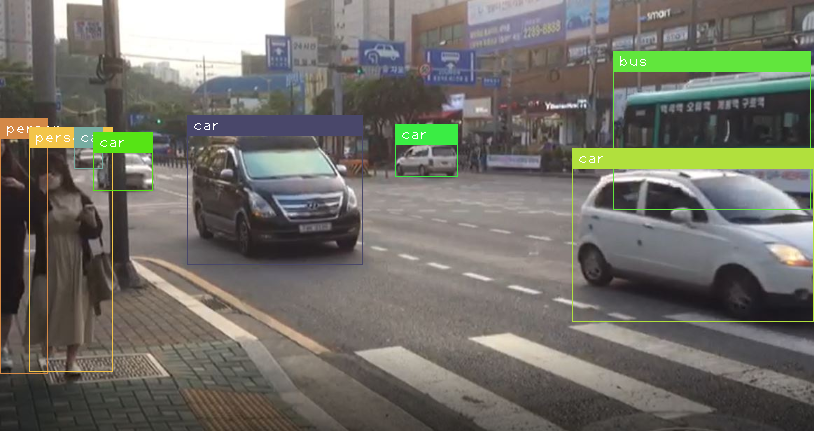

In [ ]:
# apply non-max suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)  # 박스안에 박스(노이즈)를 하나로 만들어 준다.
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:      # 노이즈가 제거된 박스만 표시해 준다.
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])   # Class 이름
        print(i, label)
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        cv2.rectangle(img, (x, y - 20), (x + w, y), color, -1)
        cv2.putText(img, label, (x + 5, y - 5), font, 1, (255, 255, 255), 1)

cv2_imshow(img)